In [7]:
import sys
import os
import pandas as pd
from sktime.datasets import load_airline
from sktime.forecasting.base import ForecastingHorizon
from sktime.forecasting.theta import ThetaForecaster
from sktime.performance_metrics.forecasting import mean_absolute_percentage_error
from sktime.split import temporal_train_test_split
from sktime.utils.plotting import plot_series
from sktime.datasets import load_airline
from sktime.forecasting.base import ForecastingHorizon
from sktime.forecasting.theta import ThetaForecaster
from sktime.performance_metrics.forecasting import mean_absolute_percentage_error
from sktime.split import temporal_train_test_split
from sktime.utils.plotting import plot_series

training_dir = os.path.join(os.path.dirname("training/"), '')
sys.path.append(training_dir)
print(training_dir)

training/


       Date  Inventory_Level
0  1/1/2017            29154
1  1/2/2017            55036
2  1/3/2017            83609
3  1/4/2017           105607
4  1/5/2017           143171


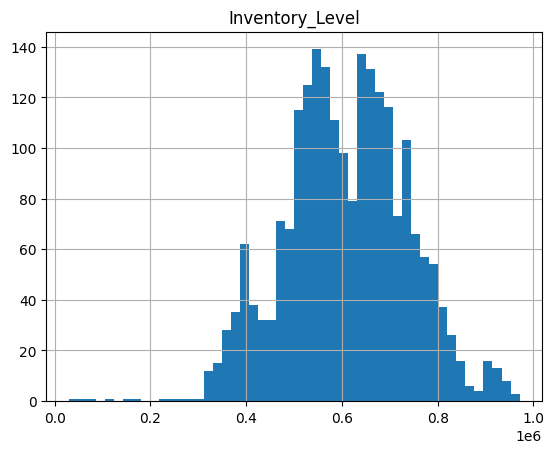

In [5]:
import matplotlib.pyplot as plt
data = pd.read_csv("src/csv/train_inventory(in).csv")
print(data.head())
data.set_index('Date', inplace=True)
data.hist(bins=50)
plt.show()


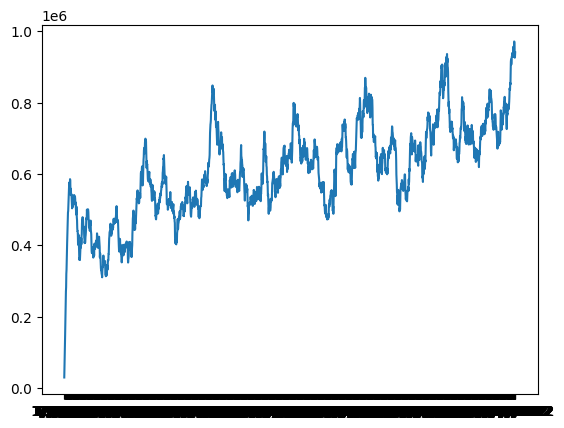

In [6]:
plt.plot(data)

In [ ]:
lin_reg_model = sklearn.linear_model.LinearRegression()
